In [1]:
%cd ..

/home/shapkin/effective-inference


## Modules

In [2]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]="3"

from typing import Tuple, List, Dict, Optional, Union
from datasets import load_dataset
from datasets.arrow_dataset import Dataset
from datasets.dataset_dict import DatasetDict

from utils.prepare_dataset import load_datasets, cut_datasets
from utils.attention_patterns.bert_module_linear import LinearClassifierBertAttention, BertWrapperLin
# from utils.attention_patterns.gpt2_module_linear import 

## Pipeline

In [3]:
from datasets import load_dataset
from transformers import AutoTokenizer, AutoModel, GPT2LMHeadModel
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, roc_auc_score
from sklearn.metrics import classification_report
from nltk.translate.bleu_score import corpus_bleu, SmoothingFunction
import torch
#from progressbar import progressbar
from tqdm.auto import tqdm

from collections import defaultdict

import seaborn as sns
from sklearn.linear_model import SGDRegressor
import matplotlib.pyplot as plt
sns.set(style='darkgrid')
import numpy as np
import json
import h5py
import os
from tqdm import tqdm
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PolynomialFeatures

### Define Parameters

In [4]:
# Define dataset
glue_classification = {'mrpc': ['sentence1', 'sentence2']}

# Define model (bert or gpt2)
model = 'bert' 
# model = 'gpt2' 

### Load Data

In [5]:
if model == 'bert':
    model_name = 'bert-base-uncased'
elif model == 'gpt2':
    model_name = 'gpt2'
else: model_name = 'bert-base-uncased'

DEBUG_FLAG = False
CUT_SIZE = None if not DEBUG_FLAG else 200

try:
    dataset_name = list(glue_classification.keys())[0]
    glue_datasets = load_datasets('glue', list(glue_classification), CUT_SIZE)
except:
    glue_classification = {'mrpc': ['sentence1', 'sentence2']}
    dataset_name = 'mrpc'
    glue_datasets = load_datasets('glue', list(glue_classification), CUT_SIZE)
    
tokenizer = AutoTokenizer.from_pretrained(model_name, max_length=1024)
initial_model = AutoModel.from_pretrained(model_name)
initial_model.eval()

# Define the device
device = 'cpu' # torch.device("cuda" if torch.cuda.is_available() else "cpu")
if device == 'cpu':
    device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
DEVICE=device
initial_model = initial_model.to(device)

In [6]:
for ex_idx, ex in tqdm(enumerate(glue_datasets[dataset_name]['train'])):
    encoded_inputs = tokenizer.encode(
                    ex['sentence1'],
                    ex['sentence2'],
                    truncation=True,
                    return_tensors='pt'
                ).to(device)
    aa = initial_model(encoded_inputs, output_hidden_states=True, output_attentions=True)

    for layer in  range(12):
        if not os.path.exists(f'notebooks/{dataset_name}/layer_{layer}'):
            os.makedirs(f'notebooks/{dataset_name}/layer_{layer}')

        for head_num in range(12): #range(aa.attentions[0].shape[1]):
            if not os.path.exists(f'notebooks/{dataset_name}/layer_{layer}/head_{head_num}'):
                os.makedirs(f'notebooks/{dataset_name}/layer_{layer}/head_{head_num}')

            current_hidden_states = aa.hidden_states[layer][0].detach().cpu().numpy()
            next_hidden_states = aa.hidden_states[layer + 1][0].detach().cpu().numpy()
            attentions = aa.attentions[layer][0][head_num].detach().cpu().numpy() # .item()

            cur_emb = aa.hidden_states[layer][0]

            with h5py.File(f'notebooks/{dataset_name}/layer_{layer}/head_{head_num}/{ex_idx}.hdf5', 'w') as f:
                f.create_dataset("current_hidden_states", data=current_hidden_states)
                f.create_dataset("next_hidden_states", data=next_hidden_states)
                f.create_dataset("attentions", data=attentions)

2803it [19:29,  2.40it/s]

KeyboardInterrupt



In [20]:
glue_datasets['mrpc']['train'][:100]

{'sentence1': ['Amrozi accused his brother , whom he called " the witness " , of deliberately distorting his evidence .',
  "Yucaipa owned Dominick 's before selling the chain to Safeway in 1998 for $ 2.5 billion .",
  'They had published an advertisement on the Internet on June 10 , offering the cargo for sale , he added .',
  'Around 0335 GMT , Tab shares were up 19 cents , or 4.4 % , at A $ 4.56 , having earlier set a record high of A $ 4.57 .',
  'The stock rose $ 2.11 , or about 11 percent , to close Friday at $ 21.51 on the New York Stock Exchange .',
  'Revenue in the first quarter of the year dropped 15 percent from the same period a year earlier .',
  'The Nasdaq had a weekly gain of 17.27 , or 1.2 percent , closing at 1,520.15 on Friday .',
  'The DVD-CCA then appealed to the state Supreme Court .',
  'That compared with $ 35.18 million , or 24 cents per share , in the year-ago period .',
  'Shares of Genentech , a much larger company with several products on the market , ros

In [21]:
def get_dataset_for_regression(prob_of_take=0.01, layer=0, head_num=0):
    X_train, y_train = [], []
    X_test, y_test = [], []
    for ex_idx, ex in tqdm(enumerate(glue_datasets['mrpc']['train'])):
        if ex_idx > 100:
            break
    # for ex_idx, ex in enumerate(glue_datasets[dataset_name]['train'][:50]):
        if np.random.choice([0, 1], size=1, p=[0.8, 0.2])[0] > 0.2:
            encoded_inputs = tokenizer.encode(
                                        ex['sentence1'],
                                        ex['sentence2'],
                                        truncation=True,
                                        return_tensors='pt'
                                    )
            # special_symbols = (encoded_inputs[0] < 103).nonzero().squeeze()
            # for head_num in range(12):
            with h5py.File(f'{dataset_name}/layer_{layer}/head_{head_num}/{ex_idx}.hdf5', 'r') as f:
    
                current_hidden_states = f['current_hidden_states'][()]
                next_hidden_states = f['next_hidden_states'][()]
                attentions = f['attentions'][()]
        
                len_of_seq = attentions.shape[0]
                for from_ in range(len_of_seq):
                    for to_ in range(len_of_seq):
                        if np.random.choice([0, 1], size=1, p=[1-prob_of_take, prob_of_take])[0] > 0.2:
                                        #feature_vector = []
                                        # (pos form, pos to, is_from_special_token, is_to_special_token,
                                        # len_of_seq, rel_position_from, rel_position_to, rev_pos_from, rev_pos_to, to_emb)
        
        
                            feature_vector = list(current_hidden_states[to_])
                            feature_vector.append(from_) # from_ pos
                            feature_vector.append(to_) # to_ pos
        
                            feature_vector.append(len_of_seq - from_) # from_ pos
                            feature_vector.append(len_of_seq - to_) # to_ pos
        
                            feature_vector.append(from_ / len_of_seq) # from_ pos
                            feature_vector.append(to_ / len_of_seq) # to_ pos
        
                            feature_vector.append((len_of_seq - from_) / len_of_seq) # from_ pos
                            feature_vector.append((len_of_seq - to_) / len_of_seq) # to_ pos
        
                            feature_vector.append(len_of_seq)
                            feature_vector.append(1/len_of_seq)
        
                            feature_vector.append(layer)
        
                                        #X_train.append(feature_vector)
                                        # y_train.append(np.log(max(attentions[from_, to_], 1e-10)))
        
                            X_train.append(feature_vector)
                            y_train.append(np.log(attentions[from_, to_]))
                        
    l = round(len(X_train)*0.95)
    X_test = X_train[l:]
    y_test = y_train[l:]
    X_train = X_train[:l]
    y_train = y_train[:l]
    
    return X_train, y_train, X_test, y_test

### Fit Linear Models

In [22]:

import numpy as np

class CustomLinearRegression:
    def __init__(self, learning_rate=0.0001, num_iterations=1000):
        self.learning_rate = learning_rate
        self.num_iterations = num_iterations
        self.weights = None
        self.bias = None

    def _initialize_weights(self, num_features):
        self.weights = np.zeros(num_features)
        self.bias = 0

    def fit(self, X, y):
        X = np.array(X)  # Convert X to a NumPy array
        y = np.array(y)  # Convert y to a NumPy array
        num_samples, num_features = X.shape
        if self.weights is None:
            self._initialize_weights(num_features)

        for _ in range(self.num_iterations):
            y_pred = np.dot(X, self.weights) + self.bias
            dw = (1 / num_samples) * np.dot(X.T, (y_pred - y))
            db = (1 / num_samples) * np.sum(y_pred - y)

            self.weights -= self.learning_rate * dw
            self.bias -= self.learning_rate * db

    def partial_fit(self, X, y):
        X = np.array(X)  # Convert X to a NumPy array
        y = np.array(y)  # Convert y to a NumPy array
        num_samples, num_features = X.shape
        if self.weights is None:
            self._initialize_weights(num_features)

        y_pred = np.dot(X, self.weights) + self.bias
        dw = (1 / num_samples) * np.dot(X.T, (y_pred - y))
        db = (1 / num_samples) * np.sum(y_pred - y)

        self.weights -= self.learning_rate * dw
        self.bias -= self.learning_rate * db

    def predict(self, X):
        X = np.array(X)  # Convert X to a NumPy array
        return np.dot(X, self.weights) + self.bias

        
    def coef_(self):
        if self.weights is None:
            raise ValueError("The model has not been fitted yet.")
        return self.weights

In [23]:
from sklearn.linear_model import Ridge, Lasso
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score
from statistics import mean
    
def learn_linear(model, y_scaler, reverse_scaler, X_train, y_train, X_test, y_test, num_examples = 5):
    # y_scaler = StandardScaler()
    y_train_scaled = y_scaler(y_train) 
    y_test_scaled = y_scaler(y_test) 

    print('Y train mean scaled:', np.mean(y_train_scaled), ', Y test mean scaled:', np.mean(y_test_scaled))
    
    model.partial_fit(X_train, y_train_scaled)

    return model

pipe_linear = CustomLinearRegression()
id_scaler = lambda x: [el for el in x]


In [24]:
X_train, y_train, X_test, y_test = get_dataset_for_regression(prob_of_take=0.3, layer=layer, head_num = i)

6it [00:00, 1448.48it/s]


FileNotFoundError: [Errno 2] Unable to open file (unable to open file: name = 'mrpc/layer_11/head_0/6.hdf5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)

In [10]:
from sklearn.metrics import r2_score, mean_squared_error
import psutil

final_models = {}
final_coefs= {}
r2_list = {i: None for i in range(12)}

for layer in [11, 10, 9, 8, 7, 6, 5, 4, 3, 2, 1, 0]:
    r2_scores = 0
    print(f'Layer {layer}')
    model = pipe_linear
    for i in range(12):
        X_train, y_train, X_test, y_test = get_dataset_for_regression(prob_of_take=0.3, layer=layer, head_num = i)
        print(psutil.cpu_percent(interval=1))
        print(f'Train: {len(X_train)}, Test: {len(X_test)}')
        model =learn_linear(model, id_scaler, id_scaler, X_train, y_train, X_test, y_test)
        preds_scaled = model.predict(X_test)
        preds = id_scaler(preds_scaled)
        r2_score_test = r2_score(y_test, preds)
        print('Test R2:', round(r2_score_test, 3))
    final_coefs[layer] = model.coef_()
    final_models[layer] = model
    r2_list[layer] = r2_score_test
    
    print()

Layer 11


4it [00:00, 524.63it/s]


14.5
Train: 0, Test: 0
Y train mean scaled: nan , Y test mean scaled: nan


/home/shapkin/.cache/pypoetry/virtualenvs/effective-inference-puaXtOsB-py3.11/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/shapkin/.cache/pypoetry/virtualenvs/effective-inference-puaXtOsB-py3.11/lib/python3.11/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


ValueError: not enough values to unpack (expected 2, got 1)

In [209]:
for layer in [11, 10, 9, 8, 7, 6, 5, 4, 3, 2, 1, 0]:
    r2_scores = 0
    model = final_models[layer]
    print(f'\nLayer {layer}\nTest R2: ')
    for head in range(12):
        X_train, y_train, X_test, y_test = get_dataset_for_regression(prob_of_take=0.3, layer=layer, head_num=head)
        preds_scaled = model.predict(X_test)
        preds = id_scaler(preds_scaled)
        r2_score_test = r2_score(y_test, preds)
        print(round(r2_score_test, 3), end=', ')
        r2_scores+=r2_score_test
    print('Test R2:', round(r2_scores/12, 3))
    r2_list[layer] = r2_scores/12

Layer 11
Test R2: 
-1.0338381813009373e+24, -2.1101127252327927e+24, -2.0353485597593304e+24, -1.7591164549034864e+24, -1.2388599466091317e+24, -1.2340844244053877e+24, -1.9185620298777632e+24, -5.946332183638694e+23, -1.264311068759002e+24, -2.7897430988708833e+24, -6.850136038467682e+23, -7.864703418000219e+23, Test R2: -1.4541744711441144e+24, Layer 10
Test R2: 
-1.930780146482044e+24, -6.728117166708672e+23, -2.3404864692550047e+24, -2.857305334276575e+24, -7.844373885954184e+23, -1.1268574522097496e+24, -1.7219426042377604e+24, -1.3391284802697502e+24, -2.628425764195192e+24, -8.055951352843256e+23, -4.1712393142078396e+23, -1.9392115089570737e+24, Test R2: -1.547008827654545e+24, Layer 9
Test R2: 
-8.199368476739781e+22, -2.3460751201718052e+23, -3.309640574320522e+23, -2.5884143354347348e+23, -2.7125862176735987e+23, -4.65437818949259e+23, -2.131544547908298e+23, -2.4239245141191015e+23, -3.1090214231561537e+23, -2.04881328193862e+23, -2.4336594759826523e+23, -5.4531156398755355

Inflection points: [2, 5, 7, 9]


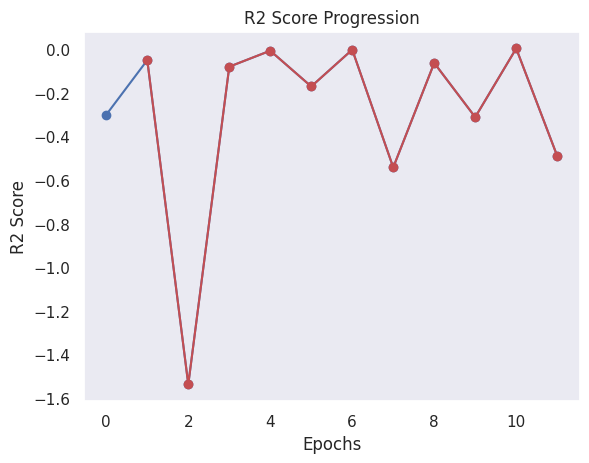

In [112]:
ans = r2_list

        
second_derivatives = []
first_derivatives = []
data = list(ans.values())
for i in range(1, len(data)-1):
    first_derivatives.append(data[i-1] - data[i])
    second_derivative = data[i+1] - 2 * data[i] + data[i-1]
    second_derivatives.append(second_derivative)
inflection_points = [i+1 for i, value in enumerate(second_derivatives) if value > 0 and first_derivatives[i]>0]
inflection_points = [list(ans.keys())[inflection_points[i]] for i in range(len(inflection_points))]

print("Inflection points:", inflection_points)

linear_layers = {}
linear_layers_r2 = {}
n = 12
for k, v in ans.items():
    if v>np.array(list(ans.values())).mean():
        n = k
    if  k >= n or k>inflection_points[0]:# and k not in inflection_points:
        linear_layers[k] = final_coefs[k]
        linear_layers_r2[k] = v

# Create x-axis values (e.g., epochs, iterations, etc.)
x_values = list(ans.keys())
y_values = list(ans.values())
x_values1 = list(linear_layers_r2.keys())
y_values1 = list(linear_layers_r2.values())
# Plot the line graphic
plt.plot(x_values, y_values, marker='o', linestyle='-', color='b')
plt.plot(x_values1, y_values1, marker='o', linestyle='-', color='r')

# Add labels and title
plt.xlabel('Epochs')
plt.ylabel('R2 Score')
plt.title('R2 Score Progression')
plt.grid()
plt.show()
# linear_layers

### Evaluate Results

In [113]:
from sklearn.impute import SimpleImputer

tqdm_pbar = lambda x, y: tqdm(x, leave=True, position=0, total=len(x), desc=f'{y}')
def get_cls_embeddings_for_dataset(dataset_name, dataset, 
                                   feature_names, model, tokenizer, 
                                   pbar_func=tqdm_pbar, device=device, CUT_SIZE=CUT_SIZE):
    collected_embeddings = defaultdict(list)

    for split, data in dataset.items():
        
        pbar = pbar_func(data, f"{split} {dataset_name}") if pbar_func is not None else data
        for example in pbar:
            # Encode the input sentences
            if len(feature_names) == 2:
                encoded_inputs = tokenizer.encode(
                    example[feature_names[0]], 
                    example[feature_names[1]], 
                    truncation=True, 
                    return_tensors='pt'
                )
            else:
                encoded_inputs = tokenizer.encode(*list(map(lambda x: example[x] , feature_names)), 
                                              truncation=True, 
                                              return_tensors='pt')
            
            special_token_positions = (encoded_inputs[0] < 103).nonzero().squeeze()
            encoded_inputs = encoded_inputs.to(device)

            # print(f"Encoded inputs: {encoded_inputs}")
            # print(f"Special token positions: {special_token_positions}")
            
            # Forward pass through the model
            with torch.no_grad():
                outputs = model(encoded_inputs)
            # print(f'Outputs: {outputs}')

            # Get the embedding of the [CLS] token
            cls_embedding = outputs.last_hidden_state[:, 0, :]

            # Append the [CLS] embedding to the list
            collected_embeddings[split].append(cls_embedding)
         
    return collected_embeddings

def train_linear(X_train, y_train):
    classifier = LogisticRegression(solver='lbfgs', max_iter=3000)
    classifier.fit(X_train, y_train)
    return classifier

def evaluate_classifier(classifier, X, y=None):
    predictions = classifier.predict(X)
    return predictions

def get_metrics_report(y_true, y_pred):
    accuracy = accuracy_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred,  average='weighted')
    print('Weighted F1', f1)
    print('Accuracy', accuracy)
    print('-------------------------------')

glue_classification = {'mrpc': ['sentence1', 'sentence2']} # , 'sst2':  ['sentence']}
superglue_classification = {'wic': ['sentence1', 'sentence2'], 'axb': ['sentence1', 'sentence2']}
all_classification = {'glue': glue_classification, 'superglue': superglue_classification}


glue_datasets = load_datasets('glue', list(glue_classification), 200)
superglue_datasets = load_datasets('super_glue', list(superglue_classification), 200)

all_datasets = {'glue': glue_datasets, 'superglue': superglue_datasets}

def check_results(custom_model, initial_model):

    for dn, datasets in all_datasets.items():
        for dataset_name, dataset in datasets.items():
            print(f"{dn.upper()} / {dataset_name}\n")

            print('Original')
            dataset_embeddings_orig = get_cls_embeddings_for_dataset(
                dataset_name,
                dataset, 
                all_classification[dn][dataset_name], 
                initial_model, 
                tokenizer)
            
            train_dataset_embeddings = torch.cat(dataset_embeddings_orig['train'], dim=0)
            valid_dataset_embeddings = torch.cat(dataset_embeddings_orig['validation'], dim=0)
            test_dataset_embeddings = torch.cat(dataset_embeddings_orig['test'], dim=0)
            
            classif = train_linear(train_dataset_embeddings.cpu(), [el['label'] for el in dataset['train']])
            valid_preds = evaluate_classifier(classif, valid_dataset_embeddings.cpu())
            print('Validation evaluation:\n')
            get_metrics_report([el['label'] for el in dataset['validation']], valid_preds)
            # print(train_dataset_embeddings.shape)

            
            print('\nLinear:')
            
            dataset_embeddings_custom = get_cls_embeddings_for_dataset(
                dataset_name,
                dataset, 
                all_classification[dn][dataset_name], 
                custom_model, 
                tokenizer)
            
            train_dataset_embeddings = torch.cat(dataset_embeddings_custom['train'], dim=0)
            valid_dataset_embeddings = torch.cat(dataset_embeddings_custom['validation'], dim=0)
            test_dataset_embeddings = torch.cat(dataset_embeddings_custom['test'], dim=0)


            classif = train_linear(train_dataset_embeddings.cpu(), [el['label'] for el in dataset['train']])
            valid_preds = evaluate_classifier(classif, valid_dataset_embeddings.cpu())
            print('Validation evaluation:\n')
            get_metrics_report([el['label'] for el in dataset['validation']], valid_preds)
            

In [161]:
device

device(type='cpu')

In [116]:
initial_model = initial_model.to(device)

custom_model = BertWrapperLin(initial_model, LinearClassifierBertAttention, final_coefs, list(range(3,12))).to(device)
# else: 
#     custom_model = GPT2WrapperLin(initial_model, LinearClassifierGPT2Attention, linear_layers,
                        # list(linear_layers.keys())).to(device)

check_results(custom_model, initial_model)

GLUE / mrpc

Original


test mrpc: 100%|██████████████████████████████| 200/200 [00:15<00:00, 13.08it/s]


Validation evaluation:

Weighted F1 0.6956793959319341
Accuracy 0.735
-------------------------------

Linear:


test mrpc: 100%|██████████████████████████████| 200/200 [00:18<00:00, 10.87it/s]


Validation evaluation:

Weighted F1 0.6496134598792063
Accuracy 0.685
-------------------------------
SUPERGLUE / wic

Original


test wic: 100%|███████████████████████████████| 200/200 [00:14<00:00, 13.87it/s]


Validation evaluation:

Weighted F1 0.5980676328502416
Accuracy 0.6
-------------------------------

Linear:


test wic: 100%|███████████████████████████████| 200/200 [00:14<00:00, 13.93it/s]

Validation evaluation:

Weighted F1 0.53004700470047
Accuracy 0.53
-------------------------------
